In [1]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
# from keras.utils import np_utils

# import h5py
import numpy as np
# from tensorflow.keras import utils
import numpy as np
from sklearn.model_selection import train_test_split
from ImageSlicer import get_random_slice
from ImageLoader import load_mmaps
import torch
from torch import tensor
import random

# To get the images and labels from file
hubble_maps = load_mmaps("HubbleArrs/hubble")
webb_maps = load_mmaps("WebbArrs/webb")
print(len(hubble_maps))
print(len(webb_maps))
dtype = torch.cuda.FloatTensor

96
8


In [2]:
entry_num = 1000
images = torch.empty(entry_num, 3, 500, 500).type(torch.cuda.FloatTensor)
labels = torch.empty(entry_num)#.type(torch.cuda.IntTensor)
for _ in range(entry_num//2):
    ten = tensor(get_random_slice(500, 500, random.choice(hubble_maps)))
    ten = torch.transpose(torch.transpose(ten, 0, 2), 1, 2)[None,...]
    images[_ * 2] = ten
    labels[_ * 2] = 0
    ten = tensor(get_random_slice(500, 500, random.choice(hubble_maps)))
    ten = torch.transpose(torch.transpose(ten, 0, 2), 1, 2)[None,...]
    images[_ * 2 + 1] = ten
    labels[_ * 2 + 1] = 1
    

print(images.size())
print(labels.size())
print("Done")
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
print("Done")
X_train, y_train, X_test, y_test = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]
print("Done")

# # building the input vector from the 32x32 pixels
X_train = X_train.reshape(X_train.shape[0], 3, 500, 500)
X_test = X_test.reshape(X_test.shape[0], 3, 500, 500)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')


torch.Size([1000, 3, 500, 500])
torch.Size([1000])
Done
Done
Done


In [3]:
# mean_image = X_train.mean(axis=0)
# std_image = X_train.std(axis=0)

# X_train -= mean_image
# X_train /= std_image

# X_test -= mean_image
# X_test /= std_image

In [4]:
%matplotlib notebook

In [5]:
#X_train = X_train.reshape(len(X_train), -1).astype(np.float32)
#X_test = X_test.reshape(len(X_test), -1).astype(np.float32)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# mean_image = X_train.mean(axis=0)
# std_image = X_train.std(axis=0)

# X_train -= mean_image
# X_train /= std_image

# X_test -= mean_image
# X_test /= std_image


In [6]:
# X_train = X_train.reshape(15962, 3, 256, 256)
# X_test = X_test.reshape(1774, 3, 256, 256)
print(X_train.size())
print(X_test.size())

torch.Size([900, 3, 500, 500])
torch.Size([100, 3, 500, 500])


In [7]:
import mygrad as mg
# import torch
from torch import tensor
import torch.nn as nn
relu = nn.functional.relu
import torch.nn as nn
import torch.nn.functional as F
import torch
# import torchvision
import torchvision.transforms as transforms
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(2,2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 16, 5)
        self.conv4 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(11664, 1166)
        self.fc2 = nn.Linear(1166,116)
        self.fc3 = nn.Linear(116, 12)
        self.fc4 = nn.Linear(12, 2)
    def forward(self, x):
        # print("forward")
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
    """
    # print(predictions.size())
    # print(truth.size())
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean((torch.argmax(prediction, dim=1) == truth).cpu().numpy())


In [8]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
train_data = X_train.to(device)
test_data = y_train.to(device).to(torch.int64)

X = X_test.to(device)
Y = y_test.to(device).to(torch.int64)
# del(X_train, y_train, X_test, Y_test)
print(X.size())


cuda
torch.Size([100, 3, 500, 500])


<IPython.core.display.Javascript object>


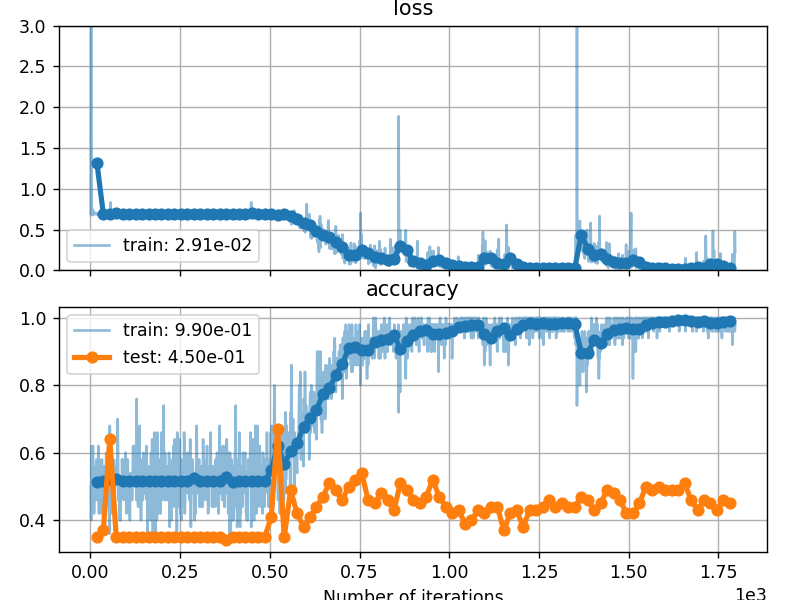

cuda


In [9]:
from noggin import create_plot
 
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

ax[0].set_ylim(0, 3)
batch_size = 50
# batch_size = 10

print(device)

In [10]:


# initialize the optimizer
model =  Model().to(device)
optim = torch.optim.Adam(model.parameters(), weight_decay=5E-3)

In [11]:
del(images)
del(labels)
# del(model)

In [12]:
for epoch_cnt in range(100):
    idxs = np.arange(len(X_train))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(0, len(X_train)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = train_data[batch_indices]  # random batch of our training data
        
        prediction = model(batch)
       
        truth = test_data[batch_indices]
        # print(prediction, truth)
        # Although its name does not indicate this, the `cross_entropy` loss
        # here also *includes a softmax* before computing the actual cross-entropy.
        loss = nn.functional.cross_entropy(prediction, truth)
        acc = accuracy(prediction, truth)
        loss.backward()
        
        optim.step()
        
        # Unlike in MyGrad, after you perform a gradient-based step with your optimizer, you
        # must explicitly delete/zero-out the gradients of your model's parameters
        # once you are done with them. MyGrad handles this for us, but PyTorch does not.
        optim.zero_grad()  
        
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size, plot=True)
    
    # This context manager simply signals to pytorch that we will not be 
    # computing any gradients (since we are only evaluating our model on
    # test data, not training on it). This will allow PyTorch to optimize
    # its computation
    with torch.autograd.no_grad():
        for batch_cnt in range(0, len(X_test)//batch_size):
            idxs = np.arange(len(X_test))
            batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
            batch = X[batch_indices] 
            prediction = model(batch)
            truth = Y[batch_indices]
            acc = accuracy(prediction, truth)
            plotter.set_test_batch({ "accuracy" : acc},
                                     batch_size=batch_size)
    plotter.set_train_epoch()
    plotter.set_test_epoch()  

In [17]:
print(loss)
print(loss.grad)

tensor(0.6953, device='cuda:0', grad_fn=<NllLossBackward0>)
None


In [14]:
print(prediction)
print(truth)
print(loss)
print(acc)

tensor([[ 8.8553e+00, -2.0023e+01],
        [-2.6245e-01, -1.7300e+00],
        [-1.6684e+00,  1.4616e+00],
        [-1.9429e+00,  1.7056e+00],
        [ 2.4599e+00, -5.8034e+00],
        [-1.0764e+00, -3.4370e-01],
        [-4.6726e-02, -1.2636e+00],
        [-6.8261e-01,  2.7518e-01],
        [ 5.5667e+00, -2.3395e+01],
        [-3.8113e+00,  3.3648e+00],
        [ 4.4103e+00, -8.4189e+00],
        [ 1.0983e+00, -2.5389e+00],
        [ 1.0479e+00, -2.6704e+00],
        [-6.7275e+00,  5.9673e+00],
        [ 4.0294e+00, -1.0138e+01],
        [ 1.0481e+00, -2.4203e+00],
        [ 7.7349e+00, -1.5447e+01],
        [ 7.8360e-01, -1.5763e+00],
        [ 1.3778e+01, -3.2504e+01],
        [ 8.3533e-01, -3.7316e+00],
        [-1.6219e+00,  1.0571e+00],
        [ 8.8582e+00, -2.5635e+01],
        [ 3.5486e+00, -7.7084e+00],
        [-5.8504e-01, -5.5233e-01],
        [-1.0303e+00,  8.5286e-01],
        [-4.1989e-01, -4.9052e+00],
        [-9.6932e-01, -5.1233e-01],
        [ 6.7371e+00, -1.617